In [1]:
import geemap
import ee



In [2]:
import xarray as xr

In [ ]:
ee.Authenticate()


In [4]:
ee.Initialize()

In [37]:
# # Import the geemap library.
# import geemap

# # Set visualization parameters.
# vis_params = {
#   'min': 0,
#   'max': 4000,
#   'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# # Create a map object.
# m = geemap.Map(center=[20, 0], zoom=3)

# # Add the elevation model to the map object.
# m.add_ee_layer(dem.updateMask(dem.gt(0)), vis_params, 'DEM')

# # Display the map.
# m

Jaxa:

In [6]:
 aoi = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
 aoi = aoi.filter(ee.Filter.eq('country_na', 'Belize'))

In [19]:
dataset_jaxa = (
    ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/FNF')
    .filterDate('2009-01-01', '2009-12-31')
    .filterBounds(aoi)
)

forest_non_forest = dataset_jaxa.select('fnf')
first = forest_non_forest.first().clip(aoi)
mask = first.eq(1)

forest_non_forest_vis = {
    'min': 1,
    'max': 2,
    'palette': ['006400', 'feff99'],
}

m = geemap.Map()
m.centerObject(aoi, 8)
m.addLayer(aoi, {}, 'aoi')
m.addLayer(first, forest_non_forest_vis, 'Forest/Non-Forest - first')
m.addLayer(mask, {'palette': ['white', 'green']}, 'Forest mask')

m

Map(center=[17.204640472242097, -88.6973939340803], controls=(WidgetControl(options=['position', 'transparent_…

GMW:

In [7]:
#Insert your year below
year = 2017

year_string = str(year)
extent_raster = ee.ImageCollection("projects/earthengine-legacy/assets/projects/sat-io/open-datasets/GMW/extent/GMW_V3")
extent_year = extent_raster.filterDate(year_string + '-01-01', year_string + '-12-31').first().clip(aoi)
mangrove_year = extent_year.eq(1)
m2 = geemap.Map()
m2.centerObject(aoi)
m2.addLayer(ee.Image().paint(aoi, 0, 2),{}, 'AOI')
m2.addLayer(mangrove_year.updateMask(mangrove_year), {'palette': ['white', 'green']}, 'Mangrove 1996')
m2

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Murray:

In [20]:
#Load dataset and clip
murray_dataset = ee.Image('JCU/Murray/GIC/global_tidal_wetland_change/2019').clip(aoi);

#Select relevant bands
lossBand = murray_dataset.select('loss');
lossYear = murray_dataset.select('lossYear');

# Define mask for years 2007–2017
recentLossMask = lossYear.gte(0).And(lossYear.lte(9));

# Apply mask to 'loss' band
periodLoss = lossBand.updateMask(recentLossMask);

# # Simplify geometry for stable export (works for FeatureCollections too)
# var simplePA = PA.geometry().simplify(100);

# Visualize
m3 = geemap.Map()
m3.centerObject(aoi, 9);
#m3.setOptions('SATELLITE');
m3.addLayer(ee.Image().paint(aoi, 0, 2),{}, 'AOI')
m3.addLayer(
  periodLoss,
  {'palette': ['fe4a49'], 'min': 1, 'max': 1},
  'Tidal wetland loss (2018–2019)'
);
m3

Map(center=[17.204640472242097, -88.6973939340803], controls=(WidgetControl(options=['position', 'transparent_…

Nasa SLR:

In [45]:
nasa_dataset = ee.ImageCollection("IPCC/AR6/SLP")

In [118]:
ssp585_2110 = ee.Image('IPCC/AR6/SLP/ssp585_2110').select('total_values_quantile_0_5')
ssp370_2110 = ee.Image('IPCC/AR6/SLP/ssp370_2110').select('total_values_quantile_0_5')

In [65]:
gulf = ee.Geometry.Rectangle([-100,15,-80,30])

In [194]:
m4 = geemap.Map()
m4.centerObject(gulf, 9)
visParams = {
  'min': 10,
  'max': 500, #TODO: Mess with this maximum number for different maximums!
  'palette': ['0000FF', '00FFFF', 'FFFF00', 'FF0000'],
}
m4.addLayer(ssp585_2110, visParams, 'SSP5-8.5 2110')
m4.addLayer(ssp370_2110, visParams, 'SSP3-7.0 2110')

# vis = ssp585_2110.visualize(min=10, max=1000, palette=['0000FF', '00FFFF', 'FFFF00', 'FF0000'])
# vis2 = ssp370_2110.visualize(min=10, max=1000, palette=['0000FF', '00FFFF', 'FFFF00', 'FF0000'])

# m4.addLayer(vis, {}, 'SSP5-8.5 2110')
# m4.addLayer(vis2, {}, 'SSP3-7.0 2110')
m4.addLayer(ee.Image().paint(gulf, 0, 2),{}, 'AOI')

m4

Map(center=[22.664895511906657, -90], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=H…

In [103]:
# stats = ssp585_2110.reduceRegion(
#     reducer=ee.Reducer.minMax(),
#     geometry=gulf,   # or ee.Geometry.Point([lon, lat]) for a quick check
#     scale=1000,
#     maxPixels=1e9
# ).getInfo()

# print(stats)

{'total_values_quantile_0_5_max': 1832, 'total_values_quantile_0_5_min': 854}


In [122]:
#Restreppo
#note - here I ran pip install xarray netCDF4 matplotlib cartopy #TODO please make sure these are in the env setup

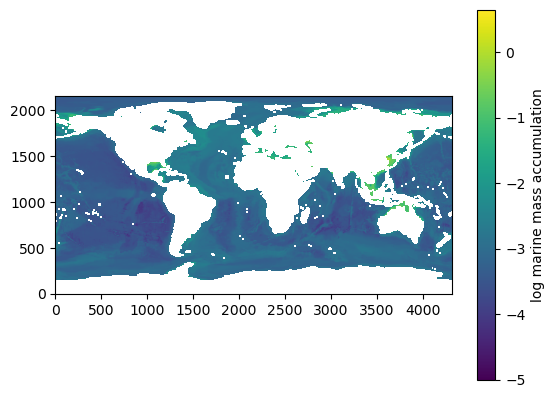

In [127]:
ds = xr.open_dataset("Log10_prediction_5m.nc")
z = ds['z']
#Perhaps, in future, convert to gtiff file that GEE can handle more easily.
import matplotlib.pyplot as plt

plt.imshow(ds.z, origin='lower', cmap='viridis')
plt.colorbar(label='log marine mass accumulation')
plt.show()

In [131]:
point_value = ds.z.sel(lat=0.0, lon=0.0, method='nearest').values
print("Value at (30N, 45W):", point_value)
#TODO - Need to figure out how to do this with arbitrary polygon files - perhaps with rioxarray and geopandas?
#try to output a map - not necessarily a geotiff, though

Value at (30N, 45W): -3.007078


Sanderman:

In [195]:
# import geemap
# import rasterio
# import numpy as np

# # Load the raster
# soc_fp = "mSOC_Dec_2017_100m.tif"
# with rasterio.open(soc_fp) as src:
#     out_image, out_transform = mask(src, aoi.geometry, crop=True)
#     out_meta = src.meta.copy()

# out_meta.update({
#     "height": out_image.shape[1],
#     "width": out_image.shape[2],
#     "transform": out_transform
# })

# # Create a geemap map
# m6 = geemap.Map(center=[0, 0], zoom=2)

# # Add the raster to the map
# m6.add_raster(soc_fp, layer_name="Mangrove SOC (tCO2/ha)")

# m6

Copernicus:

In [9]:
copernicus_dataset = ee.ImageCollection("COPERNICUS/DEM/GLO30")
DEM = copernicus_dataset.select('DEM')
DEM_global = DEM.median().toFloat()
m7 = geemap.Map()
m7.centerObject(aoi, 8)
elevationVis = {
  'min': 0,
  'max': 1000.0,
  'palette': ['0000ff','00ffff','ffff00','ff0000','ffffff'],
};
m7.addLayer(ee.Image().paint(aoi, 0, 2),{}, 'AOI')
m7.addLayer(DEM_global, elevationVis, 'DEM')

# vis = DEM.first().visualize(min=10, max=1000, palette=['0000FF', '00FFFF', 'FFFF00', 'FF0000', 'FFFFFF'])
# m7.addLayer(vis, {}, 'DEM')
#try to get a map output for DEM - map of proj area with elevation - highlight areas that will be submerged - pixel values in meters, along with a red area where it will be submerged
#possibly multiply by 1000 and turn into integer
#Keep a table - export a CSV
m7

Map(center=[17.204640472242097, -88.6973939340803], controls=(WidgetControl(options=['position', 'transparent_…

In [8]:
dem = (
    ee.ImageCollection("COPERNICUS/DEM/GLO30")
    .select("DEM")
    .mosaic()
)

point = ee.Geometry.Point([67.3, 24.3])  # lon, lat

elevation = dem.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=point,
    scale=30
)

print("Elevation (m):", elevation.getInfo()["DEM"])

#Output for DEM data should be a table of literally every pixel below a certain value

Elevation (m): 1.881144404411316


Protected Planet:

In [196]:
PP_dataset = ee.FeatureCollection("WCMC/WDPA/current/polygons")

visParams = {
  'palette': ['2ed033', '5aff05', '67b9ff', '5844ff', '0a7618', '2c05ff'],
  'min': 0.0,
  'max': 1550000.0,
  'opacity': 0.8,
}
image = ee.Image().float().paint(PP_dataset, 'REP_AREA').clip(aoi)
m8 = geemap.Map()
m8.centerObject(aoi, 8)
m8.addLayer(ee.Image().paint(aoi, 0, 2),{}, 'AOI')
m8.addLayer(image, visParams, 'WCMC/WDPA/current/polygons')
# m8.addLayer(PP_dataset, null, 'for Inspector', false)
m8

Map(center=[17.204640472242097, -88.6973939340803], controls=(WidgetControl(options=['position', 'transparent_…

In [181]:
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")

intersections = wdpa.filterBounds(aoi)

has_intersection = intersections.size().gt(0)
is_allowed = has_intersection.Not()

print("Intersects protected area:", has_intersection.getInfo())
print("AOI allowed:", is_allowed.getInfo())


Intersects protected area: 1
AOI allowed: 0


In [197]:
print(type(aoi))

<class 'ee.featurecollection.FeatureCollection'>
